# Fjerde ordens Runge-Kutta metode for drevet harmonisk pendel
## Numerisk prosjekt vår 2025
Håkon Støren og Vetle Støren

Som gitt i oppgaven har vi at 
\begin{equation*}
    \frac{\textrm{d}^2\theta}{\textrm{d}t^2} + q\frac{\textrm{d}\theta}{\textrm{d}t}+\frac{g}{l}\sin{(\theta)}=\frac{F_D}{ml}\sin{(\omega_D t)},
\end{equation*}
hvor
- $\theta$ er utslagsvinkelen til pendelen,
- $g$ er tyngdeakselerasjonen,
- $l$ er lengden av snora,
- $q$ er en friksjonsparamter,
- $\frac{F_D}{ml}$ er drivkraften som pendelen blir utsatt for,
- $\omega_D$ er drivkraftens vinkelfrekvens. \
Vi har også fra oppgaveteksten at
- $\omega_0 = \sqrt{g/l}$ og er pendelens vinkelfrekvens

Vi antar at $\sin{\theta}\approx\theta$

In [1]:
# Importerer alle bibliotekene vi trenger
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

In [7]:
# Initialiserer alle konstanter
l = 1                   # m, lengden av snora
g = 9.8                 # m/s^2, tyngdeakselerasjon
theta_0 = 0.2           # rad, initiell vinkel med hensyn til vertikalen
theta_dot_0 = 0         # rad/s, initiell vinkelhastighet
q = 1.0                 # s^-1, friksjonsparameter
w_D = 3.13              # rad/s, drivkraftens vinkelfrekvens
drivkraft = 0.2         # s^-2, F_D/(ml)
dt = 0.01
T = 20

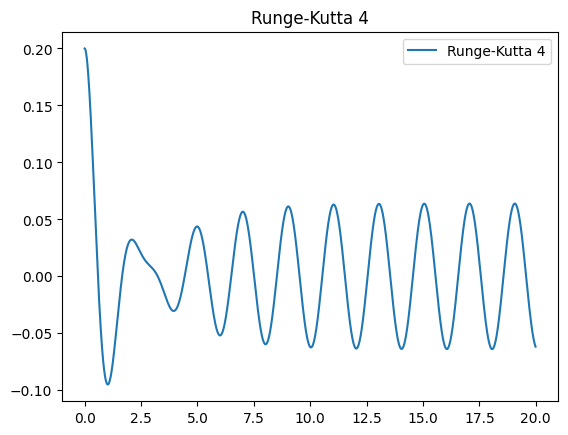

In [18]:
# 1
from typing import List

def equation(t: float, vals: List[float]):
    dw = -q*vals[1]-g/l*vals[0]+drivkraft*np.sin(w_D*t)
    dtheta = vals[1]
    
    return np.array([dtheta, dw])

def RK4_step(RHS, vals, t, dt):
    """
    Calculates one step of the RK4-algorithm.
    
    RHS: (callable) function representing the right hand side of the differential equations
    vals: (numpy array) previous values of theta and omega, [theta, omega] 
    t: (float) previous time
    dt: (float) timestep
    
    return: (array) next values [theta_next, omega_next]
    """
    k1 = RHS(t, vals)
    k2 = RHS(t+dt/2, vals+(dt/2)*k1)
    k3 = RHS(t+dt/2, vals+(dt/2)*k2)
    k4 = RHS(t+dt, vals+dt*k3)
    return vals + (dt/6)*(k1 + (2*k2) + (2*k3) + k4)

def RK4_method(RHS, theta_0, theta_dot_0, dt, T):
    """
    Computes theta and w (omega).  
    
    Parameters
    -----------
    RHS: RHS of the differential equation 
    theta0: initial value of theta
    w0: initial value of omega
    dt: timestep
    T: max t
    
    return theta, w, t
    
    """
    
    # SKRIV KODE HER
    steps = int(T/dt)
    theta = np.zeros(steps)
    theta[0] = theta_0
    w = np.zeros(steps)
    w[0] = theta_dot_0

    t = np.arange(0, T, dt)

    for i in range(1,steps):
        theta[i], w[i] = RK4_step(RHS,[theta[i-1],w[i-1]], t[i-1], dt)
    return theta, w, t


RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, dt, T)

plt.plot(RK4_t, RK4_theta, label="Runge-Kutta 4")
plt.title("Runge-Kutta 4")

plt.legend()
plt.show()

# 1
I oppgaven er Runge-Kutta 4 implementert som i numerisk øving 3.
Plottet viser løsningen av ... i løpet av 20 sekunder med dt = 0.01

In [ ]:
# 2 Euler-Cromer
def euler_cromer_approx(theta_0, theta_dot_0, dt, T):
    """
    Calculates angular displacement and angular velocity 
    using the Euler-Cromer method 
    """
    N = int(T/dt)
    t = np.linspace(0, T, N + 1)
    theta, w = np.zeros(N+1), np.zeros(N+1)
    theta[0], w[0] = theta_0, theta_dot_0
    for i in range(N):
        w[i+1] = w[i] - g/l*theta[i]*dt # CHANGE THIS
        theta[i+1] = theta[i] + w[i+1]*dt
    return theta, w, t

In [ ]:
# 2 Konvergenstest

dts = np.logspace(-3, -1, 100)


for det in dts:
    plt.plot()

plt.show()

NameError: name 'E' is not defined

# 2
Første delen av oppgaven er en implementasjon av Euler-Cromer som gjort i numerisk øving 3. 
Deretter ble en konvergenstest gjennomført for å finne den beste dt-verdien. Av de verdiene som ble testet her er ... best.

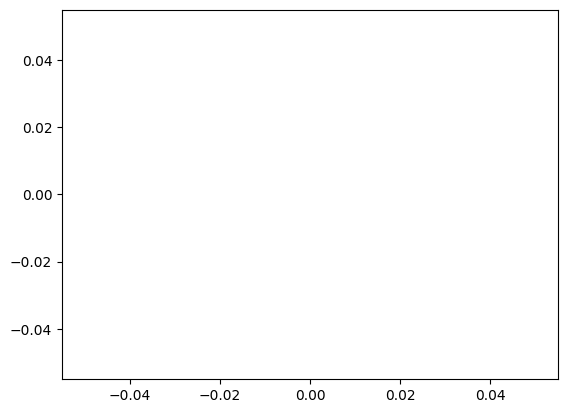

In [19]:
# 3 Ulike drivfrekvenser

freqs = np.array([1,2,3,4,5])

for freq in freqs:
    plt.plot()

plt.show()

# 3
Her er en test av ulike drivfrekvenser og plottet viser hvorden vinkelen sammenhenger med drivfrekvensen. Vi kan ut fra figuren se at ... (frekvenser når $\sqrt{\frac{g}{l}}$ gir høyest utslag)

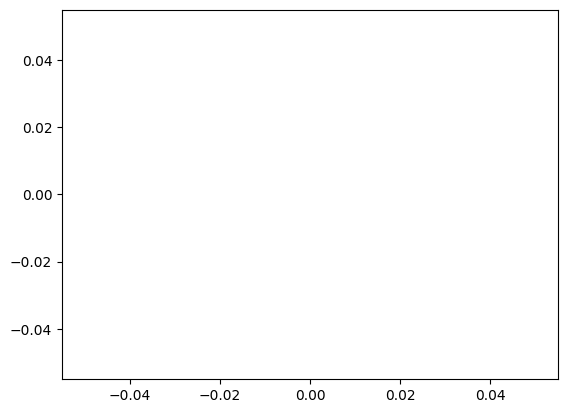

In [17]:
# 4 Undersøk resonansamplituden og friksjon

friction = np.array([1,2,3,4,5])

for fric in friction:
    plt.plot()

plt.show()

# 4
I denne oppgaven er det samme som for oppgave 3 gjort bare for friksjonen. Resultatene fra denne testen viser at ...

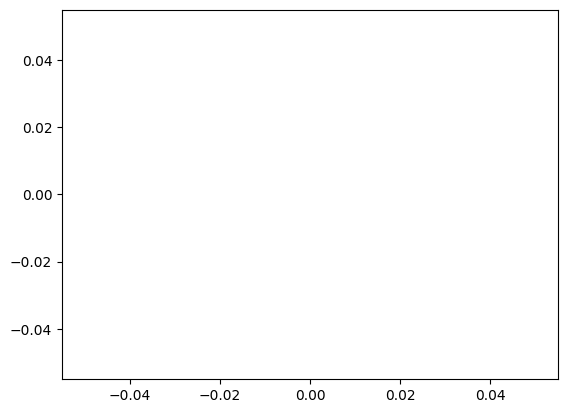

In [20]:
# 5
F_D = 0
T = 4
for fric in friction:
    plt.plot()
plt.show()

# 5
Her har vi satt drivkraften til null og undersøker, kritisk, underkritisk og overkritisk demping. Fra resultatene er det overkritisk demping med $q=$, underkritsik med $q=$ og kritisk for $q=$

In [21]:
# 6a Uten tilnærming
def equation2(t: float, vals: List[float]):
    dw = -q*vals[1]-g/l*np.sin(np.radians(vals[0]))+drivkraft*np.sin(w_D*t)
    dtheta = vals[1]
    
    return np.array([dtheta, dw])



In [ ]:
# 6b Utforsking
params = [[], []]
for param in params:
    #RK4_method(equation2, param[0], param[1], ...)
    plt.plot()

plt.show()

IndexError: list index out of range

# 6 Uten tilnærming
Her er det gjort likt som i oppgave 1 bare at vi ikke bruker vinkeltilnærmingen $\sin{\theta} = \theta$. Plotet viser vinkelutslaget fra 0 til 20 sekunder med startvinkel på 60 grader.


Til slutt er det prøvd mange ulike parametre for systemet. I plottet vises det et system med parametre ... Her ser vi at dette er kaotisk.